# Load Dependencies

## Install Libraries 

In [53]:
!pip install pandas --break-system-packages
!pip install librosa --break-system-packages
!pip install pyloudnorm --break-system-packages
!pip install tensorflow tensorflow-io --break-system-packages
!pip install pydub --break-system-packages

## Import Libaries

In [54]:
import os
import pandas as pd
import math
import numpy as np
from pydub import AudioSegment, silence
import librosa as lb
import warnings
import pyloudnorm as pyln
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten
import tensorflow_io as tfio

# Data Import

## File Paths

In [55]:
# return list of files for of given folder
def get_files(path: str, file_formats: list, exclude_dirs: list = []):
    filtered_files=[]
    for root, dirs, files in os.walk(path, topdown=True):
        if root not in exclude_dirs:
            for file in files:
                file_name, file_extension = os.path.splitext(file)
                if file_extension in file_formats:
                    file_path = root + "/" + file
                    filtered_files.append(file_path)
    return filtered_files

In [56]:
dir = "/home/helsfyr2_with_9_dbfs/"
neg_dir= "/home/helsfyr2_with_9_dbfs/neg"
file_formats= ['.wav']

pos_files = get_files(dir, file_formats, [neg_dir])
neg_files = get_files(neg_dir, file_formats)

del dir, neg_dir, file_formats

# Data Preperation

## Audio normalization

In [57]:
target_sr: int = 16000
target_loudness: float = -12.0

In [58]:
def audio_normalization(y: np.ndarray, sr: int):
    #Convert to mono
    y = lb.to_mono(y=y)

    #set sampling rate
    target_sr=16000
    y = lb.resample(y=y, orig_sr=sr, target_sr=target_sr)

    #Normalize loudness
    with warnings.catch_warnings(record=True):
        meter = pyln.Meter(rate=target_sr)
        loudness = meter.integrated_loudness(data=y)
        y = pyln.normalize.loudness(data=y, input_loudness=loudness, target_loudness=target_loudness)
    return y

## Mel diagram

In [59]:
def log_melspectogram(y: np.array, sr: int):
    y = audio_normalization(y=y, sr=sr)
    S = lb.feature.melspectrogram(y=y, sr=sr ,n_mels=128)
    return lb.power_to_db(S=S, ref=np.max)

In [60]:
def file_log_melspectograms(file_path:str, duration: float, offset: float):
    y, sr = lb.load(file_path)
    duration_total = lb.core.get_duration(y=y, sr=sr)
    S = []
    #Slicing
    for i in np.arange(0.0, duration_total-offset, offset):
        y = lb.load(file_path, mono=True, offset=i, duration=duration)[0]
        s=log_melspectogram(y=y, sr=sr)
        S.append(s)
    return np.array(S)

In [61]:
def files_log_melspectograms(file_paths:list, duration: float, offset: float):
    data_pos=[]
    for file_path in file_paths:
        for s in file_log_melspectograms(file_path=file_path, duration=duration, offset=offset):
            data_pos.append(s)
    return np.array(data_pos)

## Load data

In [62]:
def load_data_category(file_paths: list, label: str, duration:float, offset:float):
    data = files_log_melspectograms(file_paths=file_paths, duration=duration, offset=offset)
    label = np.array([label for i in range(len(data))])
    return data, label

In [63]:
#TODO  Iteration need to start from here
duration: float = 2.0

pos_data, pos_label = load_data_category(file_paths=pos_files[:100], label='announcement', duration=duration, offset=duration)
neg_data, neg_label = load_data_category(file_paths=neg_files[:100], label='no announcement', duration=duration, offset=duration)

#TODO combine pos and neg data sets
#TODO ensure that percentage of positive and negative data sets is maintained

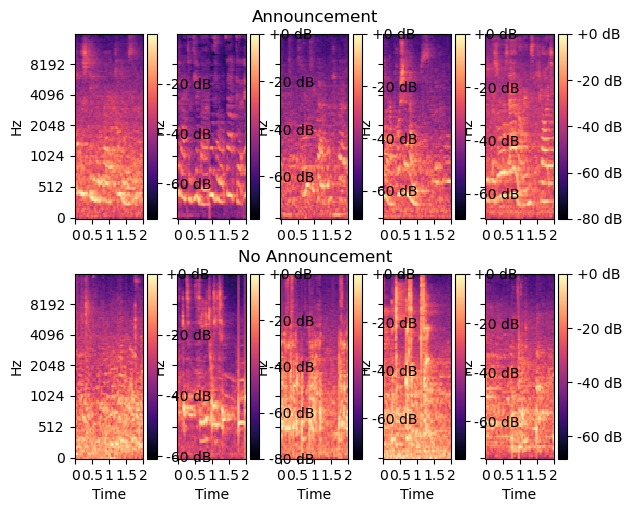

In [64]:
random.seed(42)
x=5

fig = plt.figure()
fig.suptitle('Figure title')
subfigs = fig.subfigures(nrows=2, ncols=1)
subfig_pos=subfigs[0]
subfig_neg=subfigs[1]
subfig_pos.suptitle('Announcement')
subfig_neg.suptitle('No Announcement')
axs_pos = subfig_pos.subplots(nrows=1, ncols=x, sharex=True, sharey= True)
axs_neg = subfig_neg.subplots(nrows=1, ncols=x, sharex=True, sharey= True)

for i in range(x):
    S_pos = random.choice(pos_data)
    S_neg = random.choice(neg_data)
    ax_pos = axs_pos[i]
    ax_neg = axs_neg[i]
    
    # Display spectrograms
    img_pos = lb.display.specshow(data=S_pos, x_axis='time', y_axis='mel', sr=target_sr, fmax=target_sr, ax=ax_pos)
    img_neg = lb.display.specshow(data=S_neg, x_axis='time', y_axis='mel', sr=target_sr, fmax=target_sr, ax=ax_neg)
    fig.colorbar(img_pos, ax=ax_pos, format='%+2.0f dB')
    fig.colorbar(img_neg, ax=ax_neg, format='%+2.0f dB')

plt.show()

#TODO save plot for each experiment

In [ ]:
#TODO generate training and test set

In [202]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Model

https://www.tensorflow.org/tutorials/images/cnn

In [175]:
# Create neural network
def create_cnn(train: np.ndarray):
  # get input shape
  samples, labels = train.as_numpy_iterator().next()
  input_shape = samples.shape[1:]

  # Using relu to avoid 'dead' neurons (everthing < 0 )
  model = Sequential()
  model.add(Conv2D(5, (3,3), activation='relu', input_shape=input_shape))
  model.add(Conv2D(5, (3,3), activation='relu'))
  # 3rd conv layer helped to increase precision by 5%
  model.add(Conv2D(5, (3,3), activation='relu'))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

  model.summary()

  return model

In [176]:
# Prepare model
model = create_cnn(train)
hist = model.fit(train, epochs=60, validation_data=test)

NameError: name 'train' is not defined